In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import joblib
import glob

# Load mô hình ResNet50
base_model = load_model('../models/resnet50.h5')
feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('conv5_block3_out').output)

# Load PCA và centroids
pca_model = joblib.load('../models/kmeans_k=16/pca_model.pkl') 
kmeans_models_paths = glob.glob('../models/kmeans_k=16/kmeans_label_*.pkl') 
all_centroids = np.concatenate([joblib.load(path).cluster_centers_ for path in kmeans_models_paths], axis=0)

# Load mô hình phân loại
rf_model = joblib.load('../models/random_forest/random_forest.pkl')
knn_model = joblib.load('../models/knn/knn.pkl')
mlp_model = tf.keras.models.load_model("../models/mlp/mlp.h5")

# Load scaler cho các mô hình
knn_scaler = joblib.load("../models/knn/knn_scaler.pkl")
knn_pca = joblib.load("../models/knn/knn_pca.pkl")
mlp_scaler = joblib.load("../models/mlp/mlp_scaler.pkl")

def preprocess_image(img_path):
    """ Tiền xử lý ảnh đầu vào cho ResNet50 """
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = preprocess_input(img_array)  
    return img_array

def extract_feature_map(img_path):
    """ Trích xuất đặc trưng từ ảnh bằng ResNet50 + PCA """
    img_array = preprocess_image(img_path)
    feature_maps = feature_extractor.predict(img_array)
    feature_vector = feature_maps.reshape(1, -1)  
    feature_vector_reduced = pca_model.transform(feature_vector) 
    return feature_vector_reduced

def compute_distance_vector(img_path):
    """ Tính toán vector khoảng cách đến các centroid KMeans """
    feature_vector_reduced = extract_feature_map(img_path)
    distances = np.linalg.norm(all_centroids - feature_vector_reduced, axis=1)
    return distances.reshape(1, -1) 

def predict_label(img_path):
    """ Dự đoán nhãn bằng nhiều mô hình khác nhau """
    distance_vector = compute_distance_vector(img_path)

    # KNN
    distance_vector_scaled_knn = knn_scaler.transform(distance_vector)
    distance_vector_pca_knn = knn_pca.transform(distance_vector_scaled_knn)
    knn_pred = knn_model.predict(distance_vector_pca_knn)

    # MLP
    distance_vector_scaled_mlp = mlp_scaler.transform(distance_vector)
    mlp_pred = np.argmax(mlp_model.predict(distance_vector_scaled_mlp), axis=1)

    # Random Forest
    rf_pred = rf_model.predict(distance_vector)

    return {
        "RandomForest": rf_pred[0],
        "KNN": knn_pred[0],
        "MLP": mlp_pred[0]
    }

In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import glob
import json
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

img_height, img_width = 224, 224

# Load class indices
with open("../feature_maps/class_indices.json", "r") as f:
    class_indices = json.load(f)
    index_to_class = {v: k for k, v in class_indices.items()}

def get_image_from_train(index, train_dir="../data/train"):
    """ Lấy 1 ảnh từ folder diễn viên theo index """
    actor_name = index_to_class.get(index, None)
    if actor_name is None:
        return None
    print(f"Actor Name: {actor_name}")
    actor_folder = os.path.join(train_dir, actor_name)
    img_paths = glob.glob(os.path.join(actor_folder, "*.jpeg"))
    return img_paths[0] if img_paths else None

def load_and_preprocess_image(img_path):
    """ Tiền xử lý ảnh đầu vào """
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array), img

def compute_gradcam(model, img_array, layer_name='conv5_block3_out'):
    """ Tính Grad-CAM từ ResNet50 """
    grad_model = tf.keras.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(img_array)
        class_idx = np.clip(np.argmax(preds[0]), 0, preds.shape[1] - 1)
        loss = preds[:, class_idx]
    
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap[0], 0)
    heatmap /= np.max(heatmap)
    
    # Tăng cường độ heatmap
    heatmap = np.power(heatmap, 2)
    return heatmap

def overlay_heatmap(img, heatmap):
    """ Chồng heatmap lên ảnh gốc """
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(np.array(img), 0.5, heatmap, 0.5, 0)
    return superimposed_img

def visualize_heatmaps(predictions, feature_extractor, input_img_path):
    """ Hiển thị heatmap từng ảnh riêng biệt """
    selected_images = [get_image_from_train(predictions[model]) for model in ['RandomForest', 'KNN', 'MLP']]
    selected_images = [img for img in selected_images if img is not None]
    
    input_array, input_img = load_and_preprocess_image(input_img_path)
    input_heatmap = compute_gradcam(feature_extractor, input_array)
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay_heatmap(input_img, input_heatmap))
    plt.title("Input Image Heatmap")
    plt.axis("off")
    plt.show()
    
    for i, img_path in enumerate(selected_images):
        img_array, img = load_and_preprocess_image(img_path)
        heatmap = compute_gradcam(feature_extractor, img_array)
        plt.figure(figsize=(6, 6))
        plt.imshow(overlay_heatmap(img, heatmap))
        plt.title(f"Predicted Actor {i+1}")
        plt.axis("off")
        plt.show()

In [21]:
input_img_path = '../data/test/Aaron_Eckhart/Aaron_Eckhart_5_5.jpeg'
predictions = predict_label(input_img_path)

print("Kết quả dự đoán:", predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Kết quả dự đoán: {'RandomForest': 114, 'KNN': 114, 'MLP': 375}


Actor Name: Danny_Masterson
Actor Name: Danny_Masterson
Actor Name: Nadia_Bjorlin


C:\Users\An\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_3']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


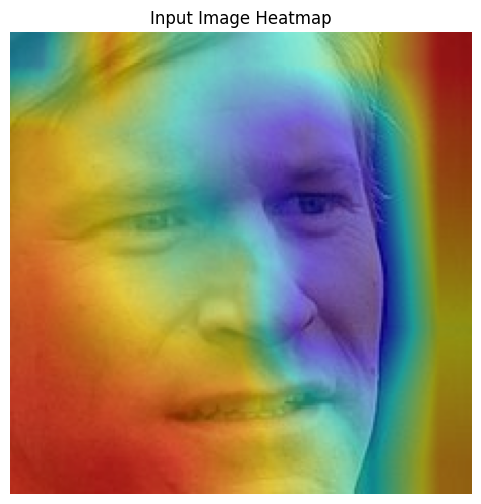

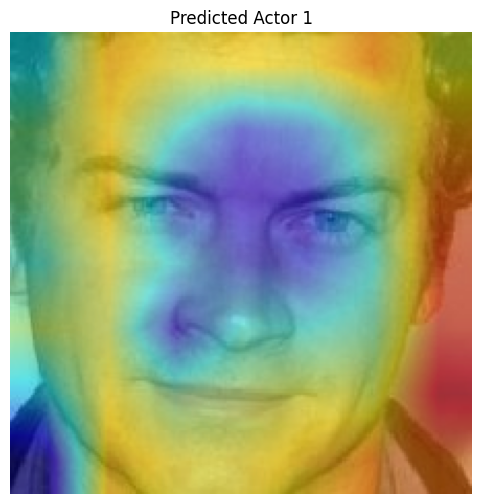

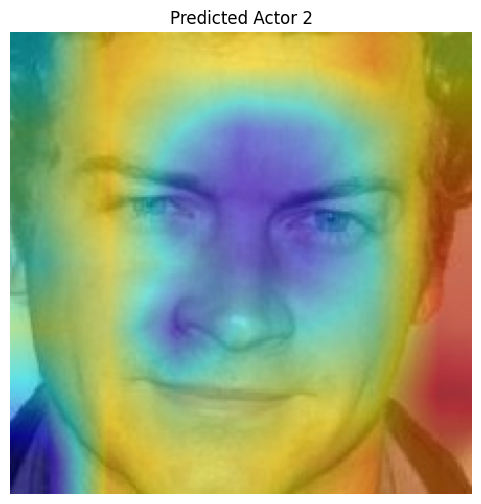

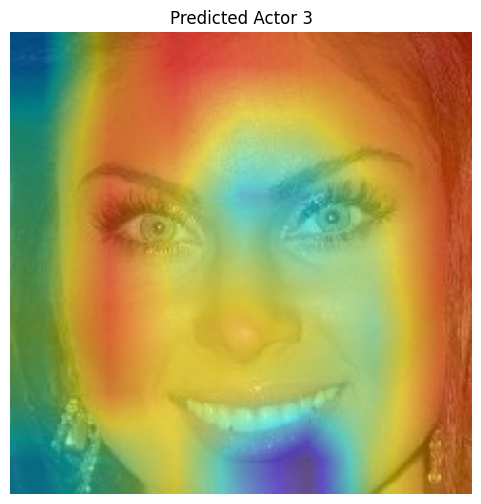

In [22]:
visualize_heatmaps(predictions, feature_extractor, input_img_path)